In [1]:
import numpy as np
import os
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
width, height = 224, 224

# Define the base directory for training images
data_dir = r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train'

# List all image paths in the 'train' directory
imagePaths = list(paths.list_images(data_dir))

data = []
labels = []

In [ ]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]  
    image = load_img(imagePath, target_size=(width, height)) 
    image = img_to_array(image)  
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

data = data / 255.0

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

labels = np.argmax(labels, axis=1)

train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

train_labels = train_labels.astype('int32')
val_labels = val_labels.astype('int32')

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")


Training data shape: (2929, 224, 224, 3)
Validation data shape: (733, 224, 224, 3)


In [ ]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),  
    Dense(5, activation='softmax') 
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:

aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

aug.fit(train_data)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    aug.flow(train_data, train_labels, batch_size=32),
    epochs=5,  
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping]
)

val_loss, val_acc = model.evaluate(val_data, val_labels)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - accuracy: 0.4637 - loss: 9.9058 - val_accuracy: 0.4052 - val_loss: 1.8609
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 769ms/step - accuracy: 0.5244 - loss: 1.7057 - val_accuracy: 0.2742 - val_loss: 5.5400
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5665 - loss: 1.3319 - val_accuracy: 0.2742 - val_loss: 2.0521
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 786ms/step - accuracy: 0.6182 - loss: 1.1419 - val_accuracy: 0.2333 - val_loss: 1.9699
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 780ms/step - accuracy: 0.6341 - loss: 1.0551 - val_accuracy: 0.6330 - val_loss: 1.1206
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6425 - loss: 1.1288
Validation Loss: 1.1205707788467407
Validation Accuracy: 0.6330150365829468


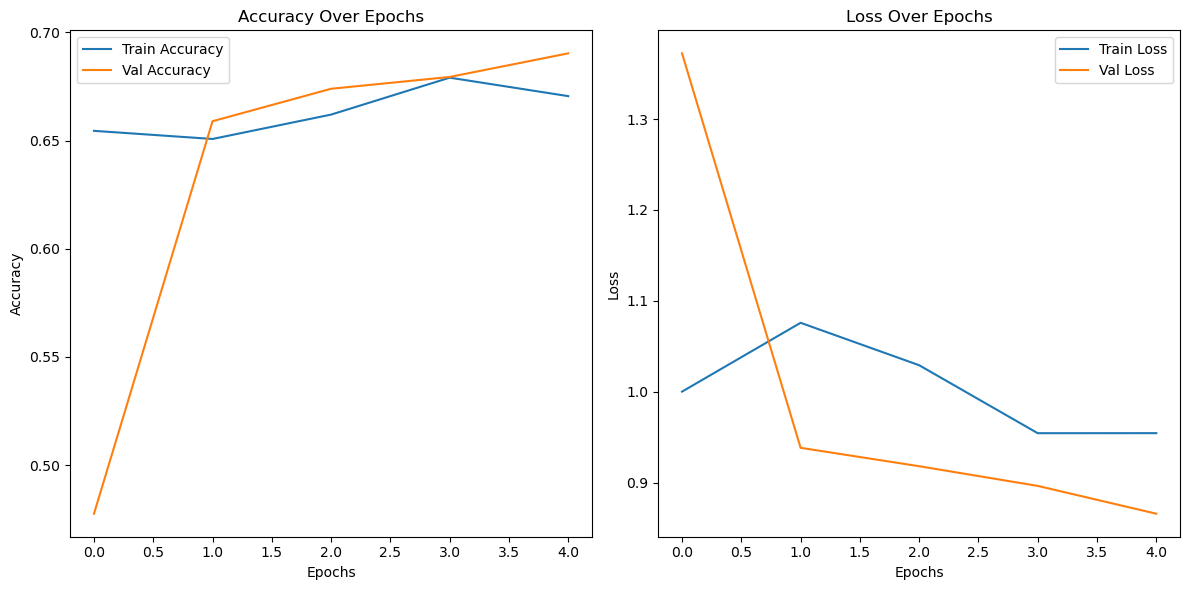

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(val_data)

y_pred_classes = y_pred.argmax(axis=1)

y_true = val_labels

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step
Accuracy: 0.6330
Precision: 0.4920
Recall: 0.6330
F1 Score: 0.5468

Confusion Matrix:
 [[  0  75  18   1   0]
 [  0 141  57   2   1]
 [  0  20 322   0   0]
 [  0  27  19   1   0]
 [  0  33  15   1   0]]


c:\Users\santhosh\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
